In [45]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4
import scipy
from scipy import stats
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns


In [46]:
# sst_file_dir = r"C:\Users\lv299\OneDrive\A_Melbourne-Uni\A_Weather_for_21st_Century_RA_Internship\Local_Remote_Influences_on_Coastal_Rainfall\Data_preparation\northeast_sst.nc"
# prec_file_dir = r"C:\Users\lv299\OneDrive\A_Melbourne-Uni\A_Weather_for_21st_Century_RA_Internship\Local_Remote_Influences_on_Coastal_Rainfall\Data_preparation\precipitation_north_east_au.nc"



In [47]:
def temporal_correlation(sst, precip):
    corr_map = xr.corr(sst, precip, dim='time')
    
    def pearson_r_pvalue(x, y):
        if np.isnan(x).any() or np.isnan(y).any():
            return np.nan
        try:
            return stats.pearsonr(x, y)[1]
        except (ValueError, ZeroDivisionError):
            return np.nan
    
    pvalue_map = xr.apply_ufunc(pearson_r_pvalue, 
                                sst, 
                                precip, 
                                input_core_dims=[['time'],['time']], 
                                vectorize=True, 
                                dask = 'parallelized')
    
    return corr_map, pvalue_map

In [48]:
def spatial_pattern_correlation(sst, precip):
    """
    compute correlation between spatial patterns at each time point

    Parameters:
    -----------
    sst: xarray.DataArray
        sea surface temperature data
    precip: xarray.DataArray
        precipitation data (daily accumulated)

    Returns:
    -----------
    time_corr: xarray.DataArray
        correlation between spatial patterns at each time point
    """

    sst_flat = sst.stack(z=('lat', 'lon'))
    precip_flat = precip.stack(z=('lat', 'lon'))

    time_corr = xr.DataArray(data = np.zeros(len(sst.time)),
                             dims = ['time'],
                             coords = {'time': sst.time})
    
    for i, t in enumerate(sst.time):
        # Extract values from the xarray data and then yeild the valid mask
        sst_values = sst_flat.sel(time=t).values
        precip_values = precip_flat.sel(time=t).values
        valid_mask = ~np.isnan(sst_values) & ~np.isnan(precip_values)

        time_corr[i] = stats.pearsonr(sst_values[valid_mask], precip_values[valid_mask])[0]






    return time_corr

In [49]:
def lagged_correlation(sst, precip, max_lag):
    """
    compute lagged correlation between SST and precipitation (SST leading precipitation)

    Parameters:
    -----------
    sst: xarray.DataArray
        sea surface temperature data
    precip: xarray.DataArray
        precipitation data (daily accumulated)
    max_lag: int
        maximum lag in days

    Returns:
    -----------
    lag_corr: xarray.DataArray
        lagged correlation between SST and precipitation
    """

    lag_corr_maps = {}

    for lag in range(max_lag + 1):
        if lag == 0:
            lag_corr_maps[lag] = xr.corr(sst, precip, dim = 'time')
        else:
            sst_shifted = sst.shift(time = -lag)

            common_time = np.intersect1d(sst.time, sst_shifted.time)
            corr = xr.corr(sst.sel(time = common_time), precip.sel(time = common_time), dim = 'time')
            lag_corr_maps[lag] = corr

            return lag_corr_maps
        

In [50]:
def plot_correlation_map(corr_map, title_text):
    plt.figure(figsize=(12,8))
    ax = plt.axes(projection=ccrs.PlateCarree())

    im = corr_map.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='RdBu_r', vmin=-0.3, vmax=0.3, add_colorbar=False)

    plt.title(title_text)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
 
    cbar = plt.colorbar(im, orientation='horizontal', pad=0.025, aspect=30)
    cbar.set_label('Pearson Correlation')

    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    boxes = [
    # Northern boxes (lat=slice(-18,-15), lon=slice(146,149), etc.)
    {'lat': (-18, -15), 'lon': (146, 149), 'color': 'red', 'label': '1'},
    {'lat': (-18, -15), 'lon': (152, 155), 'color': 'red', 'label': '2'},
    {'lat': (-18, -15), 'lon': (157, 160), 'color': 'red', 'label': '3'},
    
    # Middle boxes (lat=slice(-30,-27), lon=slice(154,157), etc.)
    {'lat': (-30, -27), 'lon': (154, 157), 'color': 'green', 'label': '1'},
    {'lat': (-30, -27), 'lon': (160, 163), 'color': 'green', 'label': '2'},
    {'lat': (-30, -27), 'lon': (167, 170), 'color': 'green', 'label': '3'},
    
    # Southern boxes (lat=slice(-40,-37), lon=slice(150,153), etc.)
    {'lat': (-40, -37), 'lon': (150, 153), 'color': 'blue', 'label': '1'},
    {'lat': (-40, -37), 'lon': (158, 161), 'color': 'blue', 'label': '2'},
    {'lat': (-40, -37), 'lon': (167, 170), 'color': 'blue', 'label': '3'},
]

# Plot each box
    for box in boxes:
        # Extract coordinates
        min_lon, max_lon = box['lon']
        min_lat, max_lat = box['lat']
        
        # Create box vertices
        lons = [min_lon, max_lon, max_lon, min_lon, min_lon]
        lats = [min_lat, min_lat, max_lat, max_lat, min_lat]
        
        # Plot box
        ax.plot(lons, lats, color=box['color'], linewidth=2, transform=ccrs.PlateCarree())
        
        # Add label in the center of the box
        center_lon = (min_lon + max_lon) / 2
        center_lat = (min_lat + max_lat) / 2
        ax.text(center_lon, center_lat, f"Box {box['label']}", color=box['color'], 
                fontweight='bold', ha='center', va='center', transform=ccrs.PlateCarree())



    plt.tight_layout()
    plt.show()

In [51]:
def plot_lagged_correlation(lag_corr_maps, title="Lagged Correlation"):
    """
    Plot lagged correlation for a specific region.
    
    Parameters:
    -----------
    lag_corr_maps : dict
        Dictionary of correlation maps at different lags
    region : tuple, optional
        Region to average over as (min_lat, max_lat, min_lon, max_lon)
    title : str
        Plot title
    """
    lags = sorted(lag_corr_maps.keys())
    corr_values = []
    
    for lag in lags:
        regional_corr = lag_corr_maps[lag].mean().values
        corr_values.append(regional_corr)
    
    plt.figure(figsize=(10, 10))
    plt.plot(lags, corr_values, 'o-', linewidth=2)
    plt.grid(True, alpha=0.3)
    plt.xlabel('Lag (time steps)')
    plt.ylabel('Correlation Coefficient')
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [52]:
# dir for mac

sst_file_dir = "/Users/richard_zhang/Library/CloudStorage/OneDrive-Personal/A_Melbourne-Uni/A_Weather_for_21st_Century_RA_Internship/Local_Remote_Influences_on_Coastal_Rainfall/Data_preparation/OISST/northeast_sst.nc"
prec_file_dir = "/Users/richard_zhang/Library/CloudStorage/OneDrive-Personal/A_Melbourne-Uni/A_Weather_for_21st_Century_RA_Internship/Local_Remote_Influences_on_Coastal_Rainfall/Data_preparation/TRMM/northeast_precip.nc"

In [ ]:
sst_oisst = xr.open_dataarray(sst_file_dir)

sst_oisst = sst_oisst.loc[0: 8034,:, :]

precip = xr.open_dataarray(prec_file_dir)

date_time = pd.date_range(start='1998-01-01', periods=8034, freq='D')

sst_oisst['time'] = date_time

precip['time'] = date_time


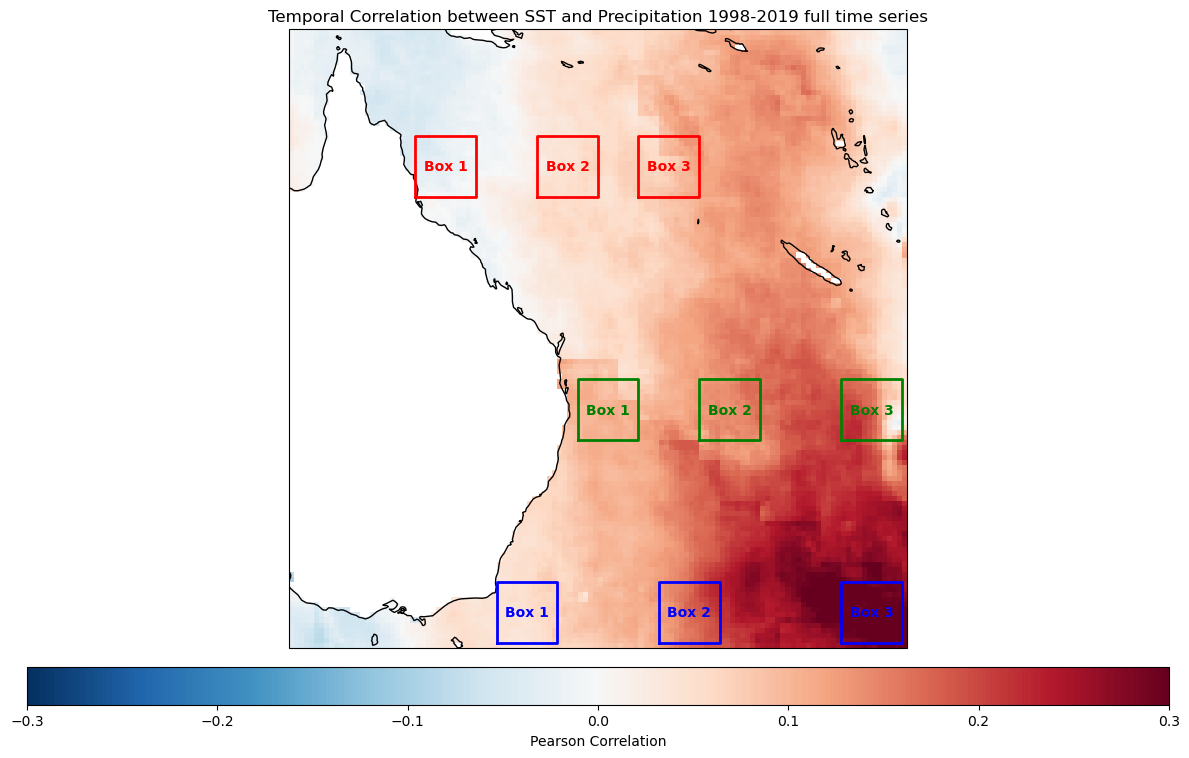

In [57]:
def main():
    """
    Main function to run the analysis.
    """
    # Paths to your data files

    
    # Load and preprocess data
    sst_data = sst_oisst
    precip_data = precip
    
    # Compute temporal correlation at each grid point
    corr_map, pvalue_map = temporal_correlation(sst_data, precip_data)
    title_text="Temporal Correlation between SST and Precipitation 1998-2019 full time series"
    # Plot temporal correlation map
    plot_correlation_map(corr_map, title_text)

    # # Compute spatial pattern correlation at each time step
    # time_corr = spatial_pattern_correlation(sst_data, precip_data)
    
    # # Plot time series of spatial pattern correlation
    # plt.figure(figsize=(12, 9))
    # time_corr.plot()
    # plt.grid(True, alpha=0.3)
    # plt.title("Spatial Pattern Correlation between SST and Precipitation")
    # plt.xlabel("Time")
    # plt.ylabel("Correlation Coefficient")
    # plt.tight_layout()
    # plt.show()
    
    # # Compute lagged correlation
    # lag_corr_maps = lagged_correlation(
    #     sst_data, precip_data, max_lag=15)
    
    
    # # Plot lagged correlation for ENSO region
    # plot_lagged_correlation(
    #     lag_corr_maps, 
    #     title="Lagged Correlation (SST leading Precipitation) in ENSO Region")

if __name__ == "__main__":
    main()
